In [1]:
import import_ipynb
import logging
import numpy as np
from optparse import OptionParser
import os
import sys
from time import time
import matplotlib.pyplot as plt
import random  
from random import sample 
import pandas as pd
import pickle
import scipy
from tempfile import mkdtemp
from shutil import rmtree

from sklearn.compose import make_column_selector
# from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from sklearn.decomposition import PCA, NMF, KernelPCA, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import roc_curve
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import My_Transformers
from sklearn.preprocessing import StandardScaler
# Global var
TRAIN_ROW_COUNT = 7964
from My_Transformers import *
from Word2Vec_Transformer import Text_cleaner_transformer
import warnings
warnings.filterwarnings ("ignore")

# Global vars
VERSION = 'Best_80'
trainDF = None
testDF  = None
sclf_1_1, sclf_1_2, sclf_1_3, sclf_2_1 = None, None, None, None
lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1 = None, None, None, None, None, None, None
TRAIN_SAMPLE_WEIGHT = None
CACHEDIR = mkdtemp()

importing Jupyter notebook from My_Transformers.ipynb
importing Jupyter notebook from Word2Vec_Transformer.ipynb


2020-09-26 08:19:51,110 INFO adding document #0 to Dictionary(0 unique tokens: [])
2020-09-26 08:19:51,112 INFO built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [2]:
def pickleSave (obj, file):

    if VERSION != '':

        file, ext = os.path.splitext (file)
        file += "_v" + str (VERSION) + ext
    dirs = os.path.dirname (file) 
    if dirs:
        os.makedirs (dirs, exist_ok=True)
    with open (file, 'wb') as f:
        pickle.dump (obj, f)
    return

def unpickle (file):

    if VERSION != '':

        file, ext = os.path.splitext(file)
        file += "_v" + str(VERSION) + ext
    return pickle.load (open (file, 'rb'))

In [3]:
class Discrete2OneHot_FeatureTransformer (BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        self.LB_1 = None
        self.LB_2 = None
        return

    def fit (self, X, y=None, **fit_params):
        print ('Discrete2OneHot_FeatureTransformer: fit(): X.shape =', X.shape)
        self.LB_1 = LabelBinarizer ()
        self.LB_1.fit (list (X['keyword']))
        self.LB_2 = LabelBinarizer ()
        self.LB_2.fit (list (pd.isnull (X['location'])))
        return self

    def transform (self, X, y=None, **fit_params):
        
        A = self.LB_1.transform (list (X['keyword']))
        B = self.LB_2.transform (list (pd.isnull (X['location']))).reshape (-1, 1)
        X = np.hstack ((A, B))
        print ('Discrete2OneHot_FeatureTransformer: transform(): X.shape =', X.shape)
        return X

# FV Trainers

In [4]:
# Global vars

pca_nmf_ft = ColumnTransformer ([ ('pca_nmf', Pipeline ([
        
        ('tfidf_vectorizer',        TfidfVectorizer (analyzer='char', ngram_range=(3, 7), max_df=0.90, min_df=5, token_pattern='(\S+)')),
        ('sparse_svm_feat_select1', SparseSVM_feature_selector ()),
        ('interactions',            PolynomialFeatures (2, interaction_only=True, include_bias=False)),
        ('sparse_svm_feat_select2', SparseSVM_feature_selector ()),
        ('standardization',         StandardScaler (with_mean=False)),
        ('pca_nmf',                 PCA_NMF_TrainTest_FeatureTransformer (isSparseOut=True))
], memory=CACHEDIR), 'text')])


tfidf_ft = ColumnTransformer ([ ('tfidf', Pipeline ([

        ('tfidf_vectorizer',        TfidfVectorizer (analyzer='char', ngram_range=(3, 7), max_df=0.90, min_df=5, token_pattern='(\S+)')),
        ('sparse_svm_feat_select1', SparseSVM_feature_selector ()),
        ('interactions',            PolynomialFeatures (2, interaction_only=True, include_bias=False)),
        ('sparse_svm_feat_select2', SparseSVM_feature_selector ()),
        ('standardization',         StandardScaler (with_mean=False))
], memory=CACHEDIR), 'text')])


pca_category_ft = ColumnTransformer ([
        ('keyword_category', Discrete2OneHot_FeatureTransformer (), ['keyword', 'location']),
        ('tfidf_pca',        Pipeline ([

            ('tfidf_vectorizer',        TfidfVectorizer (analyzer='char', ngram_range=(3, 7), max_df=0.90, min_df=5, token_pattern='(\S+)')),
            ('sparse_svm_feat_select1', SparseSVM_feature_selector ()),
            ('interactions',            PolynomialFeatures (2, interaction_only=True, include_bias=False)),
            ('sparse_svm_feat_select2', SparseSVM_feature_selector ()),
            ('standardization',         StandardScaler (with_mean=False)),
            ('pca',                     PCA_NMF_TrainTest_FeatureTransformer (isNMF=False, isSparseOut=False))
        ], memory=CACHEDIR), 'text')
])

In [5]:
def init ():
    
    global pca_nmf_ft, tfidf_ft, pca_category_ft, trainDF
    train_file = "Data/all.csv"
    trainDF = pd.read_csv (train_file)
    # df = df[0:20]
    trainDF['text'] = trainDF.text.astype (str)
    trainDF['keyword'] = trainDF.keyword.astype (str)
    trainDF['location'] = trainDF.location.astype (str)
    
    # pca_nmf_ft.fit (trainDF, trainDF['target'])
    # tfidf_ft.fit (trainDF, trainDF['target'])
    # pca_category_ft.fit (trainDF, trainDF['target'])
    return

In [6]:
init ()

# L-0 Classifiers

In [7]:
# Global vars

lsvc_1 = Pipeline ([
    ('pca_nmf_ft', pca_nmf_ft),
    ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
], memory=CACHEDIR)
lsvc_1.name = 'lsvc_1'

lsvc_2 = Pipeline ([
    ('tfidf_ft',   tfidf_ft),
    ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
], memory=CACHEDIR)
lsvc_2.name = 'lsvc_2'

lsvc_3 = Pipeline ([
    ('pca_category_ft', pca_category_ft),
    ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
], memory=CACHEDIR)
lsvc_3.name = 'lsvc_3'

catb_1 = Pipeline ([
    ('pca_nmf_ft', pca_nmf_ft),
    ('clf',        Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
], memory=CACHEDIR)
catb_1.name = 'catb_1'

catb_2 = Pipeline ([
    ('tfidf_ft',   tfidf_ft),
    ('clf',        Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
], memory=CACHEDIR)
catb_2.name = 'catb_2'

catb_3 = Pipeline ([
    ('pca_category_ft', pca_category_ft),
    ('clf',             Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
], memory=CACHEDIR)
catb_3.name = 'catb_3'

fcnn_1 = Pipeline ([
    ('pca_category_ft', pca_category_ft),
    ('clf',             Best_clf_cv_transformer ({ 'name': 'FCNN'}))
], memory=CACHEDIR)
fcnn_1.name = 'fcnn_1'

# Stacking Classifiers

In [8]:
# Global vars
# Level 1

sclf_1_1 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1], 
                               meta_classifier=Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
sclf_1_1.name = 'sclf_1_1'

sclf_1_2 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1],
                               meta_classifier=Best_clf_cv_transformer ({ 'name': 'RF',    'params': {'class_weight': 'balanced', 'n_estimators': 3, 'max_features': None} }))
sclf_1_2.name = 'sclf_1_2'

sclf_1_3 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1],
                               meta_classifier=Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False }))
sclf_1_3.name = 'sclf_1_3'

# Level 2

sclf_2_1 = StackingClassifier (classifiers=[sclf_1_1, sclf_1_2, sclf_1_3],
                                 meta_classifier=Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
sclf_2_1.name = 'sclf_2_1'

In [9]:
def train (clf):
    
    clf.fit (trainDF, trainDF['target'])
    return

In [10]:
def predict (clf, iterCount=0):
    
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[0:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    
    predictions = clf.predict (testDF)
    testDF['target'] = predictions
    testDF['target'] = testDF.target.astype (int)
    submitDF = testDF[['id', 'target']]
    submitDF.to_csv ('submission_v'+str (VERSION) + clf.name + '.' + str (iterCount+1) + '.csv', index=False)
    return

In [11]:
# init ()
# train (sclf_2_1)
# predict (sclf_2_1)

In [12]:
def main (clf, threshold=0.9, maxIterCount=10, thresh_depreciation=0.01):

    global trainDF, sclf_2_1
    newTrainAddCount = 1
    iterCount = 0
    while newTrainAddCount > 0:

        threshold = threshold - iterCount * thresh_depreciation
        if iterCount >= maxIterCount:
            break
        train (clf)
        predict (clf, iterCount)
        Pr = sclf_2_1.predict_proba (trainDF)
        newTrainAddCount = 0
        for idx, row in trainDF.iterrows ():
            if not pd.isnull (row['target']):

                continue
            pr = Pr[idx]
            p  = 0
            if pr[0] > 0.5:
                pr = pr[0]
                p  = 0
            else:
                pr = pr[1]
                p  = 1
            if pr >= threshold:
                # add in the training set
                trainDF.at[idx, 'target'] = p
                newTrainAddCount += 1
        # arrange df such that 1st rows with y=0/1 then rows with y=NaN
        arrangedDF1 = trainDF[pd.isnull (trainDF['target']) == False]
        arrangedDF2 = trainDF[pd.isnull (trainDF['target'])]
        trainDF = pd.concat ([arrangedDF1, arrangedDF2], axis=0)
        iterCount += 1
    # trainDF.to_csv ('Data/all_'+str (VERSION) + clf.name + '.' + str (iterCount+1)+'.csv', index=False)
    train (clf)
    predict (clf, iterCount)

    # CV for the bclfs on the original train rows
    print ('------------------- CV for the sclf_2_1 on the original train rows -------------------')
    trainDF = trainDF[:TRAIN_ROW_COUNT]
    cv_results = []
    cv_result = cross_validate (sclf_2_1, trainDF, cv=5)
    cv_score = np.mean (cv_result['test_score'])
    print ()
    print (clf.name, cv_score)
    print (cv_result)
    rmtree (CACHEDIR)
    return

# ROC Curves

In [13]:
def adjusted_classes (y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [14]:
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    return

In [15]:
def plot_roc_curve (fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    return

In [16]:
def roc_for_clf (clf):
    
    global TRAIN_ROW_COUNT, trainDF
    print ('-------------------------- ROC for', clf.name, '---------------------------')
    
    # init ()
    y_train_scores = clf.predict_proba (trainDF[:TRAIN_ROW_COUNT])[:, 1]
    y_train = list (trainDF[:TRAIN_ROW_COUNT]['target'])
    
    # ROC curve : don't understand this ?
    fpr, tpr, auc_thresholds = roc_curve (y_train, y_train_scores)
    print ('AUC =', auc (fpr, tpr))         # AUC of ROC
    plot_roc_curve (fpr, tpr, 'recall_optimized')
    
    # plot Precisioin, Recall vs Threshold
    p, r, thresholds = precision_recall_curve (y_train, y_train_scores)
    plot_precision_recall_vs_threshold (p, r, thresholds)
    
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    submitDF = testDF[['id', 'target']]
    y_test_scores = clf.predict_proba (testDF)[:, 1]
    for pr in thresholds:
        
        submitDF['target'] = adjusted_classes (y_test_scores, pr)
        submitDF['target'] = submitDF.target.astype (int)
        print (pr, sum (list (submitDF['target'])))

LinearSVC with L1-based feature selection for X.shape = (11471, 138022)
--------------------- Best parameter (CV score=0.825):
{'classifier__C': 1, 'feature_selection__estimator__tol': 0.0001}
New #features =  1353
LinearSVC with L1-based feature selection for X.shape = (11471, 915981)
--------------------- Best parameter (CV score=0.854):
{'classifier__C': 10, 'feature_selection__estimator__tol': 0.001}
New #features =  1341
Find optimal PCA dims and the same no. of NMF features for X.shape = (11497, 1341)
--------------------- Best:  parameters = (0.9, 0.1) , CV = 0.8811112505932017
PCA dimensionality, explainedVarRatio =  804 0.9
training LSvc for X.shape = (11471, 1608)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.884):
{'C': 0.005}
Done Fitting LSvc
training LSvc for X.shape = (11471, 1341)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.875):
{'C': 0.005}
Done Fitting LSvc
Discrete2OneHot_FeatureTransformer: fit(): X.shape = (11497, 2)
Discrete2OneHot_Fea

      3        0.1389       0.6204        0.1155  0.2070
      4        0.0979       0.6307        0.0814  0.1960
      5        0.0737       0.6275        0.0631  0.2260
      6        0.0578       0.6307        0.0495  0.2300
      7        0.0473       0.6313        0.0394  0.2450
      8        0.0400       0.6373        0.0329  0.2061
      9        0.0336       0.6340        0.0282  0.2130
     10        0.0301       0.6378        0.0238  0.2430
     11        0.0261       0.6432        0.0206  0.2200
     12        0.0238       0.6394        0.0183  0.1920
     13        0.0215       0.6400        0.0164  0.2050
     14        0.0202       0.6416        0.0143  0.2280
     15        0.0183       0.6449        0.0130  0.2330
     16        0.0168       0.6400        0.0119  0.2020
     17        0.0155       0.6465        0.0107  0.2200
     18        0.0147       0.6449        0.0098  0.2310
     19        0.0134       0.6427        0.0089  0.2530
     20        0.0127       0.6

     24        0.0115       0.7304        0.0054  0.2420
     25        0.0111       0.7315        0.0051  0.2220
     26        0.0108       0.7326        0.0050  0.2700
     27        0.0098       0.7309        0.0046  0.2210
     28        0.0098       0.7353        0.0042  0.2060
     29        0.0092       0.7298        0.0039  0.2420
     30        0.0093       0.7304        0.0038  0.2200
     31        0.0088       0.7342        0.0038  0.2430
     32        0.0085       0.7320        0.0034  0.2330
     33        0.0077       0.7337        0.0032  0.2160
     34        0.0079       0.7347        0.0031  0.2110
     35        0.0077       0.7304        0.0029  0.2450
     36        0.0074       0.7380        0.0029  0.2180
     37        0.0069       0.7364        0.0027  0.2180
     38        0.0067       0.7429        0.0026  0.2390
     39        0.0067       0.7358        0.0024  0.2120
     40        0.0063       0.7353        0.0024  0.2120
  epoch    train_loss    valid_

     34        0.0071       0.7587        0.0034  0.2370
     35        0.0067       0.7598        0.0032  0.2360
     36        0.0072       0.7631        0.0029  0.2060
     37        0.0061       0.7587        0.0031  0.2160
     38        0.0060       0.7598        0.0028  0.2130
     39        0.0058       0.7554        0.0028  0.2260
     40        0.0054       0.7582        0.0027  0.2510
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4012       0.6100        0.2947  0.2060
      2        0.2195       0.6683        0.1852  0.2040
      3        0.1388       0.6759        0.1225  0.2100
      4        0.0962       0.6868        0.0884  0.2410
      5        0.0720       0.6977        0.0653  0.2520
      6        0.0561       0.6993        0.0515  0.2120
      7        0.0452       0.7064        0.0394  0.2140
      8        0.0379       0.7190        0.0330  0.2531
      9        0.0317       0.7

     13        0.0213       0.7304        0.0213  0.2060
     14        0.0196       0.7320        0.0189  0.2100
     15        0.0180       0.7320        0.0173  0.2310
     16        0.0161       0.7375        0.0161  0.2400
     17        0.0151       0.7407        0.0145  0.2120
     18        0.0138       0.7402        0.0135  0.2470
     19        0.0130       0.7397        0.0120  0.2310
     20        0.0122       0.7353        0.0111  0.2220
     21        0.0116       0.7440        0.0103  0.2100
     22        0.0110       0.7500        0.0099  0.2830
     23        0.0107       0.7418        0.0093  0.2570
     24        0.0099       0.7402        0.0085  0.2160
     25        0.0097       0.7489        0.0081  0.2070
     26        0.0093       0.7484        0.0078  0.2100
     27        0.0092       0.7440        0.0072  0.2590
     28        0.0089       0.7446        0.0067  0.2310
     29        0.0085       0.7473        0.0065  0.2240
     30        0.0078       0.7

     36        0.0053       0.7569        0.0015  0.4390
     37        0.0051       0.7638        0.0015  0.5600
     38        0.0050       0.7617        0.0014  0.4460
     39        0.0049       0.7634        0.0013  0.4350
     40        0.0045       0.7560        0.0012  0.4520
FCNN : cv_score:   0.768
Done Fitting FCNN
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11497, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11497, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11497, 223)
training RF for X.shape = (11471, 7)
RF : Best_clf_cv_transformer: starting CV = 5
RF : cv_score:   0.975
Done Fitting RF
training LSvc for X.shape = (11471, 1608)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.884):
{'C': 0.005}
Done Fitting LSvc
training LSvc for X.shape = (11471, 1341)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.875):
{'C': 0.005}
Done Fitting LSvc
training LSvc for X.shape = (11471, 1027)
LSvc : Best_clf_

      3        0.1692       0.6155        0.1313  0.2470
      4        0.1123       0.6051        0.0874  0.2360
      5        0.0798       0.6035        0.0617  0.2460
      6        0.0597       0.6035        0.0463  0.2000
      7        0.0489       0.6024        0.0364  0.2630
      8        0.0401       0.6035        0.0301  0.2440
      9        0.0347       0.6046        0.0251  0.1970
     10        0.0303       0.6024        0.0212  0.2280
     11        0.0285       0.6084        0.0181  0.2191
     12        0.0255       0.6144        0.0165  0.2280
     13        0.0228       0.6209        0.0144  0.2390
     14        0.0207       0.6269        0.0128  0.2280
     15        0.0190       0.6291        0.0116  0.1980
     16        0.0177       0.6318        0.0104  0.2810
     17        0.0165       0.6362        0.0096  0.2151
     18        0.0156       0.6394        0.0089  0.2580
     19        0.0151       0.6432        0.0081  0.2500
     20        0.0141       0.6

     24        0.0103       0.7462        0.0062  0.2310
     25        0.0093       0.7473        0.0057  0.2570
     26        0.0096       0.7527        0.0056  0.2100
     27        0.0097       0.7505        0.0052  0.2230
     28        0.0085       0.7522        0.0049  0.2140
     29        0.0086       0.7522        0.0047  0.2461
     30        0.0085       0.7511        0.0044  0.2200
     31        0.0078       0.7522        0.0041  0.1970
     32        0.0081       0.7533        0.0040  0.2100
     33        0.0070       0.7505        0.0038  0.2280
     34        0.0069       0.7484        0.0035  0.2020
     35        0.0069       0.7516        0.0035  0.2220
     36        0.0070       0.7544        0.0033  0.2529
     37        0.0064       0.7554        0.0032  0.2320
     38        0.0066       0.7544        0.0031  0.2270
     39        0.0066       0.7636        0.0029  0.2090
     40        0.0060       0.7571        0.0029  0.2160
  epoch    train_loss    valid_

New #features =  1141
LinearSVC with L1-based feature selection for X.shape = (7964, 651511)
--------------------- Best parameter (CV score=0.763):
{'classifier__C': 1, 'feature_selection__estimator__tol': 0.0001}
New #features =  1114
Find optimal PCA dims and the same no. of NMF features for X.shape = (7964, 1114)
--------------------- Best:  parameters = (0.9, 0.1) , CV = 0.8081946883884774
PCA dimensionality, explainedVarRatio =  679 0.9
training Catb for X.shape = (7964, 1358)
Done Fitting Catb
-------------------------- ROC for catb_1 ---------------------------
AUC = 0.9962756353546466
0.08336233436577846 2563
0.08337397006099968 2563
0.08343045881680569 2563
0.0834755880868685 2563
0.0834773921250362 2563
0.0834915525138348 2563
0.0835110899529295 2563
0.08353098441732114 2562
0.08355959321941915 2562
0.08356573391375607 2562
0.08365217891975142 2562
0.08367383620387375 2561
0.0836910584358972 2561
0.08370339847473274 2561
0.0837226315310496 2561
0.08376058967663434 2561
0.0837

0.09574984579521358 2457
0.09583438709712772 2457
0.09586348336385402 2457
0.09594557728117392 2456
0.09600025672621254 2456
0.09600562919855854 2456
0.09601169332287304 2456
0.09614468725972809 2455
0.09616882126638167 2455
0.0961835984725924 2455
0.09619997158551215 2455
0.09624614738506433 2455
0.09628387152554574 2454
0.0964229195946651 2452
0.09644137768963275 2452
0.09645129715412595 2452
0.09646053996737683 2452
0.0964821287770327 2451
0.09667279039056118 2448
0.09669970507848502 2448
0.09673244510056472 2448
0.09680075015049705 2448
0.09680217760223161 2448
0.096863633031569 2446
0.09691384915525277 2446
0.09695422541405116 2446
0.09696259361632455 2446
0.09696544553752337 2445
0.09705054549392812 2445
0.09714396081304207 2444
0.09718000033214844 2444
0.09720129159959191 2444
0.09720319670667774 2443
0.09724580656382319 2443
0.09727587205427349 2442
0.09728882579207532 2442
0.0973122441930801 2442
0.09732871157630325 2442
0.09735911717390197 2442
0.09738318838529003 2442
0.0974

0.11228207127164401 2337
0.11236931186907115 2335
0.1124050623399258 2335
0.11241589912098653 2335
0.11242076910519684 2335
0.11245161412704908 2335
0.11250043212988046 2335
0.11252313812244634 2335
0.1126652872764578 2334
0.11275167183456815 2333
0.11284407112195705 2333
0.11292215032108262 2333
0.11294138431510112 2333
0.11299008066093832 2332
0.11306935782288502 2330
0.11319313170565329 2329
0.11319927285875853 2329
0.11321456463571018 2329
0.11327315191949144 2327
0.11328610699507365 2326
0.11341388011714099 2325
0.11353794432773232 2324
0.1136496935648074 2322
0.11367521782475228 2322
0.1137049912183379 2322
0.11374957403400221 2322
0.11381492492580267 2322
0.11382685656820218 2322
0.11387040372542791 2322
0.11390923968430519 2319
0.11400966489127383 2316
0.11402604577142071 2316
0.1140636403111274 2316
0.11413037044354189 2315
0.11423812636864474 2315
0.11427386433644512 2315
0.1142915361406634 2315
0.11433982069471123 2314
0.11434065722416333 2314
0.11435398581882429 2314
0.1144

0.13146648504007485 2194
0.1315820614178997 2194
0.1320368070097164 2193
0.13218827884553128 2189
0.13222969594852518 2189
0.13225148693422792 2189
0.1322626879242012 2189
0.13229309841797815 2189
0.1323139522767437 2188
0.1323607084846845 2188
0.13258937902923168 2185
0.1325924421087587 2185
0.13259345160298974 2185
0.13269400939089115 2185
0.13273249406694912 2185
0.1329111813572526 2185
0.13301705854320037 2185
0.1331428825541316 2184
0.13326280676957702 2184
0.13355842202563653 2184
0.13358900490147213 2184
0.13384130920143092 2182
0.1339375168527947 2182
0.13399867479420935 2182
0.1340604294276529 2182
0.13411497285102503 2182
0.1341620131924 2182
0.13416691617992937 2182
0.13416818642511874 2182
0.13435236117939428 2181
0.13441103536357094 2180
0.13447358194245 2180
0.1344869716668217 2180
0.1345017747958506 2180
0.13455280431548106 2180
0.134678565412396 2180
0.1346832480100993 2179
0.13468718701685578 2179
0.13469598327376917 2179
0.13471134288769804 2179
0.13478243513380628 21

0.1610023553448657 2045
0.16109635768874722 2043
0.1612871474844955 2043
0.1614404445932801 2043
0.1615573241856671 2042
0.1616482221899412 2042
0.16170885330781018 2042
0.16175111100053263 2041
0.1617895323732277 2040
0.16190478777334125 2040
0.16201460105607698 2040
0.1620157428615661 2040
0.16211018271454958 2040
0.16216909649352135 2038
0.16224965319690735 2038
0.16230134820035652 2036
0.16232131557912063 2036
0.16247261501089177 2036
0.16250381547002332 2035
0.16257139372858476 2035
0.16262248999352658 2035
0.16282991535578825 2034
0.16287010569707744 2033
0.1631011201549689 2033
0.16323020799189664 2033
0.16336101115659066 2032
0.16339236706830468 2032
0.16341176382514902 2032
0.16343495521109158 2032
0.16345827967856766 2032
0.16347859807159767 2032
0.16355895204944798 2032
0.1636186244942549 2032
0.16374330340631868 2031
0.16380765074776255 2031
0.16381579385397305 2031
0.16412821879910172 2029
0.16431331338974667 2028
0.16436698518250326 2028
0.16458839344461096 2027
0.1647547

0.20655348956160594 1861
0.2065605010215266 1861
0.20679886076181897 1861
0.2068206903333778 1861
0.2073409973895479 1860
0.20734557886605956 1860
0.20788655793304966 1856
0.20819034923310287 1855
0.20825275873251264 1855
0.2083387527856334 1855
0.2084750714112367 1855
0.20902163879087177 1854
0.20924634888522736 1854
0.20977089398221438 1853
0.2098028037683581 1853
0.20986839756816458 1853
0.2102253932407135 1852
0.21031124314521887 1851
0.21091467455226603 1851
0.21114794990781954 1850
0.21128221829240976 1850
0.21136497208238048 1850
0.21142367152484606 1850
0.2114930215314916 1850
0.2115039543486831 1850
0.21168932789175107 1850
0.21228226494713567 1848
0.2126659924391569 1846
0.21273753776458257 1845
0.21280126684171355 1845
0.21306463057375408 1845
0.21322245006273394 1844
0.21326353085129482 1844
0.2134536605303677 1843
0.21417132272582473 1842
0.21430008260272793 1841
0.21432368559329623 1841
0.21436341493631805 1841
0.21440128664868424 1839
0.21474818955814984 1839
0.215036517

0.29121745200884125 1637
0.2915081614168445 1636
0.2915426788270176 1636
0.2924916295227389 1634
0.2928577118671817 1633
0.29311867966006994 1633
0.2935782197991753 1631
0.29403579889410975 1630
0.2943281228736028 1629
0.29454466536083806 1628
0.29505860662251127 1626
0.2957059952955263 1621
0.2963721494383553 1619
0.2964850995286238 1619
0.29655344782560444 1619
0.2967998667543926 1619
0.29727688238837024 1618
0.29756478460905506 1617
0.2978455436857456 1616
0.298426276127634 1615
0.29899103807576505 1613
0.29924807361653105 1613
0.30050269809346797 1610
0.3021269332534916 1605
0.30231482859109854 1605
0.3024181771084307 1605
0.30255532736750607 1605
0.3034946405135652 1604
0.3036029868435373 1602
0.3036896882567491 1602
0.30422026477590847 1602
0.3043080725782594 1601
0.30450346080321694 1601
0.3046794334155378 1601
0.3049791698636166 1600
0.30515834155411387 1600
0.30550747742882667 1600
0.3061200166483207 1599
0.3064828601460922 1596
0.30780113847457774 1595
0.30803100159459845 159

0.5320100522227685 1202
0.5325854436698783 1202
0.5330295157305268 1201
0.5337585602465161 1201
0.5343003010897566 1201
0.534786246959823 1198
0.536136339058624 1196
0.5370847817712077 1195
0.5374863440158966 1195
0.5378241805944496 1195
0.5396106755501924 1189
0.5397649101843496 1189
0.540413384030289 1188
0.5405405657857559 1188
0.5407071132498343 1187
0.5410824476071503 1187
0.5417762567966151 1186
0.5420741306650676 1185
0.5440306425749293 1183
0.5456147269628471 1180
0.5462309770889302 1179
0.5470997360408556 1179
0.5477567091030218 1178
0.547787370300477 1178
0.5482296073312357 1178
0.5483899785465527 1178
0.548441093305969 1178
0.5493306880891049 1178
0.5497248609369221 1178
0.5508209805105019 1177
0.5528100198161534 1173
0.5531109008015025 1172
0.5536111071509933 1170
0.5539619377668502 1169
0.5540900059978772 1169
0.5540935771150256 1169
0.5556207985941833 1167
0.5564243583132643 1166
0.5565018231800826 1166
0.5579184339966441 1166
0.5590111077865306 1165
0.5593533655153748 11

0.7325818708800054 886
0.732622791051519 886
0.7327750498709329 886
0.7330286596999233 885
0.7331199154439916 885
0.7335194145092402 884
0.7338323679209613 884
0.7339277460728869 882
0.7340747324821658 882
0.7341275126443002 882
0.7355702491943112 880
0.73558918969433 880
0.73566619393078 880
0.7357442947810847 879
0.7359321504165266 879
0.736042510427556 879
0.7360909891000414 879
0.7361413176407577 879
0.7363717435354803 879
0.7365675853432887 879
0.7365982448932108 879
0.7368648880955128 879
0.7369849371810817 879
0.7371243222903886 879
0.7377133035994868 878
0.738015132394478 878
0.7381850440819856 877
0.7383402517320667 876
0.7386993484297719 875
0.7389825808793149 874
0.7392141472476587 874
0.7392580613382619 874
0.7393516005608455 874
0.7395318652130899 873
0.7396996071723614 873
0.7403314637091946 871
0.7406755137470702 871
0.7408147912446483 871
0.7410479699633089 869
0.7418181861299247 867
0.7420292658747689 867
0.7420666845111178 867
0.7422389187430604 867
0.7429232282229568

0.8187668852159673 731
0.8188648873034201 731
0.8189839612378402 731
0.8190040877734954 731
0.8190399570397419 731
0.819262368748855 730
0.8195973298581957 728
0.819850117754309 728
0.8198724476214099 728
0.8198843041490176 727
0.8200610252933953 727
0.8200897090695738 727
0.8201265778637568 726
0.820955995452903 725
0.8211481921629451 725
0.8214746089957697 725
0.8214926613138963 725
0.8218187129833717 724
0.8220191200642575 723
0.8220686607931138 723
0.8220762936266964 723
0.8221928611127753 723
0.8228985412059465 721
0.823060128470154 721
0.8230900455332868 719
0.8230927438237301 719
0.8232902936806816 719
0.8236071011303128 719
0.8236826452704141 718
0.8237541484998534 718
0.8238763136598567 718
0.8239541501735395 718
0.8240509687275118 718
0.8240548608532301 718
0.8244130488115095 717
0.8245440651659112 717
0.8248659187155956 716
0.8249600671600469 716
0.8252319483146376 716
0.8254045736998894 716
0.8257502983707027 716
0.8257732476403471 716
0.8258571555308657 716
0.8258683927274

0.8809809111571919 583
0.8810077077643542 583
0.8810124177154801 583
0.8810660246187045 583
0.8811174300752507 582
0.8812002763946593 582
0.8812254557096104 582
0.8812760931598098 582
0.8814749329457602 581
0.8814786728737288 581
0.8815461732592649 581
0.8815922799044921 581
0.8816315109754795 581
0.8817624524876698 580
0.8821367140975682 579
0.8825398075824297 577
0.8829085979222518 577
0.883074652729343 577
0.8832196148448885 577
0.883246455085597 577
0.8832562083716802 577
0.8832714995807369 576
0.8833197538130507 576
0.8834158511843915 576
0.8838259273184298 576
0.8839124915803753 576
0.8840809816803337 576
0.884107120749225 576
0.8843740201565795 576
0.8844834638772995 576
0.8845842861095538 576
0.8846313622534884 574
0.8847180091692487 574
0.8847959580086519 574
0.8848110064773654 574
0.8848388236789697 574
0.884951007521892 573
0.8849748073740881 573
0.8851551257677881 573
0.885278969954505 572
0.8853158838088669 572
0.8853743703213596 572
0.8854071563125406 571
0.88542420893981

0.9240379667926423 465
0.9241304727987675 465
0.9242418203726268 464
0.9244098497449965 463
0.9244400724415891 463
0.9245422217967301 463
0.924696553516643 463
0.924720516623102 463
0.9247926459763651 463
0.9247989805292463 462
0.9248622554926763 462
0.9248693953895548 462
0.9250885893737847 462
0.9251667984433689 461
0.9253311772696035 461
0.9254323116118424 461
0.9254372193195955 461
0.9254714590702854 461
0.9255349950269147 461
0.9255371565522416 461
0.9257094299979904 460
0.9257116100153178 460
0.9257909014380211 458
0.9257935836968003 458
0.9258863249224805 457
0.9259065290709925 457
0.9259214172787017 456
0.9259754102663226 456
0.9260066268991681 456
0.9260242958593967 456
0.92619068477196 456
0.9262644497567424 455
0.9262772917278458 455
0.9262786345565697 455
0.9262805220066832 455
0.9263329174899515 455
0.92635549903331 455
0.9264944884714192 455
0.9266408412694582 455
0.9267652834220712 455
0.9267850131368919 455
0.9269873828590699 455
0.9271337587202635 455
0.927139739876295

0.9570886010429014 303
0.9571109699886096 303
0.957136329643125 303
0.9571807653525498 303
0.9571887469337006 303
0.9572086451827676 303
0.957223207701243 303
0.9572306976922909 302
0.9573522384517338 301
0.9574399578309598 301
0.9574735107157106 298
0.9574869873935192 298
0.9574928293493574 297
0.9575869477487267 297
0.9576091951195085 297
0.9576574517251161 297
0.9576621832049178 297
0.9577574685113779 296
0.957767185360367 296
0.9578009175370802 295
0.9578237985894995 295
0.9578797461766885 294
0.9579390795753308 294
0.9579517984002176 294
0.9579948026569562 294
0.9580030958723017 294
0.9580060427035372 294
0.9580934872450125 292
0.9581447313543837 292
0.9581447360100054 292
0.9582789947318129 292
0.9583046973403001 292
0.9585415289178494 291
0.9585627239527847 291
0.9586765055074017 291
0.9587222287619124 291
0.9587769457429013 291
0.9587838197722166 290
0.9589300226872631 290
0.9589653878990786 290
0.9589931743085669 290
0.9591302426456386 289
0.9591449312186748 289
0.959188745188

0.9749132529244108 155
0.9749424355013075 155
0.9749488285540143 154
0.9749582787819735 154
0.9749737417671669 153
0.9750064205622652 153
0.9751451172206123 151
0.9751942605810754 151
0.9752152396756859 151
0.9753322355549069 151
0.9753746828300952 149
0.9753796351381644 149
0.975487029443636 149
0.9755096522932833 149
0.9756079703872151 149
0.9756519369370599 149
0.9756665367975946 149
0.9756701614055018 149
0.9757369166698207 147
0.9758736995731255 145
0.975884094592398 144
0.9759283878388202 144
0.9759343001737568 144
0.9759531418507764 144
0.976045796366597 144
0.9760508527430677 144
0.9760732257234895 144
0.9761377401298463 144
0.9761408323693984 144
0.976184240702754 143
0.9763095411297824 143
0.976310663922135 143
0.9763497339096069 143
0.9764331985698842 143
0.9765168628640297 143
0.9765250813329788 143
0.9765602901439234 143
0.9765803569274654 143
0.9766255991957307 141
0.9766491394361458 141
0.9767039100489947 140
0.976726426626313 140
0.9768158137230286 138
0.976878938478034

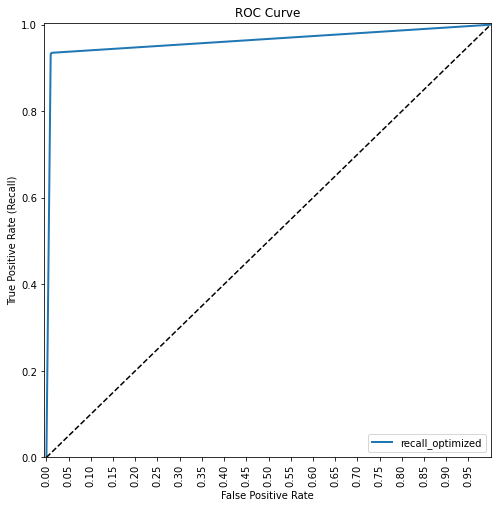

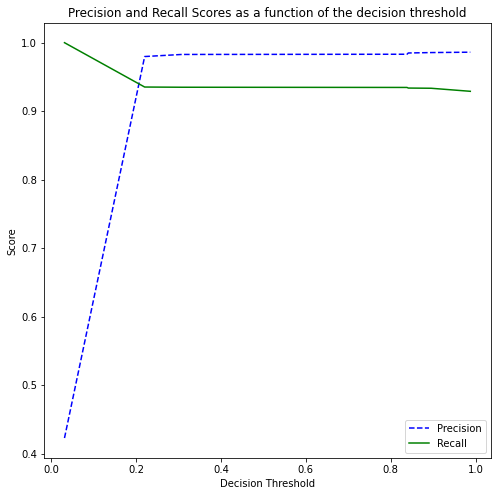

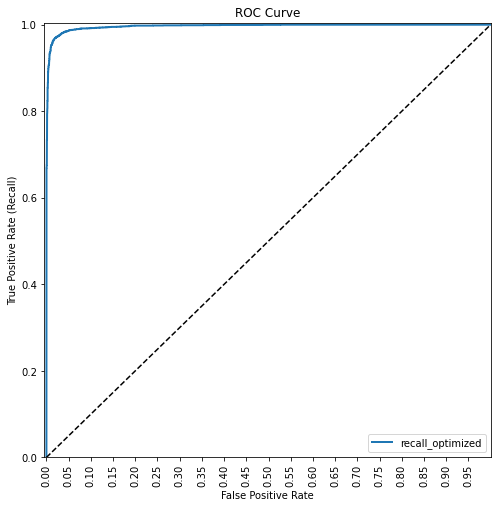

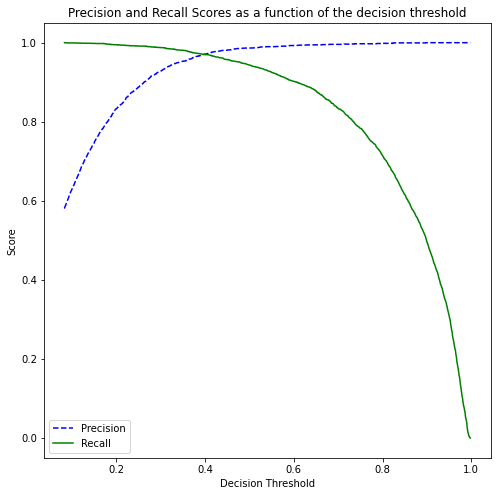

In [17]:
main (sclf_2_1, maxIterCount=1)
roc_for_clf (sclf_2_1)

train (catb_1)
roc_for_clf (catb_1)

In [18]:
def predict_threshold (clf, threshold_pr):
    
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    submitDF = testDF[['id', 'target']]
    y_test_scores = clf.predict_proba (testDF)[:, 1]
    
    submitDF['target'] = adjusted_classes (y_test_scores, threshold_pr)
    submitDF['target'] = submitDF.target.astype (int)
    submitDF.to_csv ('submission_v'+str (VERSION) + clf.name + '.roc'+ str (threshold_pr) + '.csv', index=False)

In [21]:
predict_threshold (sclf_2_1, 0.9876329819404077)
predict_threshold (catb_1, 0.6278707926066012)

# clean file
import re
text_cleaner_transformer = Text_cleaner_transformer ()
files = ["Data/all.csv", "Data/train.csv", "Data/test.csv"]
for file in files:
    df = pd.read_csv (file)
    df['text'] = text_cleaner_transformer.transform (df['text'])
    df.to_csv (file, index=False)

# Findings

LinearSVC with L1-based feature selection for X.shape = (7964, 83758)

--------------------- Best parameter (CV score=0.693):

{'feature_selection__estimator__tol': 0.001}

New #features =  1393

LinearSVC with L1-based feature selection for X.shape = (7964, 970921)

--------------------- Best parameter (CV score=0.765):

{'feature_selection__estimator__tol': 0.0001}

New #features =  1374

Find optimal PCA dims and the same no. of NMF features for X.shape = (11227, 1374)

--------------------- Best:  parameters = (0.9, 0.1) , CV = 0.8258456437870457

PCA dimensionality, explainedVarRatio =  784 0.9

training LSvc for X.shape = (7964, 1568)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.829):

{'C': 0.005}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1374)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.818):

{'C': 0.005}
Done Fitting LSvc
Discrete2OneHot_FeatureTransformer: fit(): X.shape = (11227, 2)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Find optimal PCA dims for X.shape = (11227, 1374)

--------------------- Best:  parameters = (0.9, 0.1) , CV = 0.8258456437870457

PCA dimensionality, explainedVarRatio =  784 0.9
training LSvc for X.shape = (7964, 1007)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.826):

{'C': 0.005}

Done Fitting LSvc

training Catb for X.shape = (7964, 1568)
Done Fitting Catb

training Catb for X.shape = (7964, 1374)

Done Fitting Catb

training Catb for X.shape = (7964, 1007)

Done Fitting Catb

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)


Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

training LSvc for X.shape = (7964, 6)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.973):

{'C': 1}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1568)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.829):

{'C': 0.005}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1374)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.818):

{'C': 0.005}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1007)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.826):

{'C': 0.005}

Done Fitting LSvc

training Catb for X.shape = (7964, 1568)

Done Fitting Catb

training Catb for X.shape = (7964, 1374)

Done Fitting Catb

training Catb for X.shape = (7964, 1007)

Done Fitting Catb

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

training RF for X.shape = (7964, 6)

RF : Best_clf_cv_transformer: starting CV = 5

RF : cv_score:   0.973

Done Fitting RF

training LSvc for X.shape = (7964, 1568)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.829):

{'C': 0.005}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1374)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.818):

{'C': 0.005}

Done Fitting LSvc

training LSvc for X.shape = (7964, 1007)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.826):

{'C': 0.005}


Done Fitting LSvc

training Catb for X.shape = (7964, 1568)

Done Fitting Catb

training Catb for X.shape = (7964, 1374)

Done Fitting Catb

training Catb for X.shape = (7964, 1007)

Done Fitting Catb

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

training Catb for X.shape = (7964, 6)

Done Fitting Catb


Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (11227, 223)

training LSvc for X.shape = (7964, 3)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.974):

{'C': 0.005}

Done Fitting LSvc

In the next iteration the final output CV score improved as:

training LSvc for X.shape = (11471, 3) (11471,)

LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.979):

# without any cleaning, this scored 80 % in the kaggle test !